In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# To describe how **smoothing price spikes** with techniques like **Gaussian smoothing** can be beneficial, you want to focus on the **practical implications** of reducing volatility in electricity prices. Here's how you might structure your explanation:

### How Smoothing Price Spikes is Beneficial:

1. **Stabilizing the Electricity Market**:
   - **Price volatility** in the electricity market can create uncertainty for both suppliers and consumers. Sharp spikes in prices can make it difficult to plan consumption and supply effectively. By smoothing out these price spikes, the market becomes more stable.
   - A **more stable price environment** encourages long-term contracts and planning, benefiting both electricity producers and large consumers (like industrial companies).

2. **Reducing the Impact of Short-term Fluctuations**:
   - Many price spikes are caused by **short-term fluctuations** in demand and supply. These can be due to factors such as sudden changes in weather or grid failures. By applying smoothing techniques, we can reduce the impact of these short-lived disruptions on the overall price.
   - **Gaussian smoothing** allows the system to react less aggressively to temporary spikes and provides a **more accurate reflection of long-term trends** in electricity prices.

3. **Improving Decision-making for Consumers**:
   - Consumers, especially large industries, often rely on price forecasts to plan their energy usage. **Smoother price forecasts** allow them to avoid overreacting to short-term spikes and help them plan their energy consumption more efficiently.
   - This can lead to **cost savings**, as consumers can avoid high-cost periods by making more informed decisions based on smoothed price data.

4. **Encouraging Efficient Energy Use**:
   - Sharp price spikes can create **panic behavior** in the market, causing both consumers and producers to react in ways that are not energy-efficient (e.g., hoarding energy during low-price periods, or quickly scaling up generation in anticipation of spikes).
   - Smoothing out price spikes encourages more **rational energy consumption** and **generation practices**, improving overall system efficiency.

5. **Mitigating Financial Risk for Stakeholders**:
   - Both producers and consumers face significant **financial risks** when electricity prices are volatile. Sharp spikes can lead to unpredictable costs for consumers and missed opportunities for suppliers who may not be able to respond quickly enough to capitalize on high prices.
   - By smoothing the prices, the **financial risks** for all parties are reduced, making the market more predictable and less exposed to sudden shocks.

6. **Supporting Grid Management**:
   - **Grid operators** rely on price signals to manage electricity generation and distribution. Smoothing out price spikes can make grid management more predictable, reducing the likelihood of **grid imbalances** caused by sudden demand surges or supply shortages.
   - This can lead to fewer instances of grid failures and **blackouts**, as the grid operators are better able to manage supply and demand in a more stable pricing environment.

7. **Enhancing Forecast Accuracy**:
   - Smoothed price data can improve the **accuracy of predictive models** for future price movements. By reducing the noise and sharp volatility in historical data, models can learn the underlying trends more effectively, leading to **better price predictions**.
   - This enhanced forecast accuracy benefits **energy traders**, **regulators**, and **market participants**, all of whom rely on accurate price forecasts to make informed decisions.

### In Summary:

Smoothing price spikes can provide **numerous benefits**, including:
- **Market stability**, which leads to better decision-making for both consumers and producers.
- **Reduced financial risk** for all stakeholders by making prices more predictable.
- **Improved grid management** through more stable price signals.
- **Increased efficiency** in energy use and generation practices.
- **Enhanced forecast accuracy**, which allows for more informed and strategic market participation.

In [9]:
# Load all the dataset we have
demand_actual = pd.read_csv('nsw_demand_actual.csv')
demand_forecast = pd.read_csv('nsw_demand_forecast.csv')
prices = pd.read_csv('nsw_prices.csv')
solar = pd.read_csv('nsw_solar.csv')
weather = pd.read_csv('CCtemps.csv')

# Fixing data and time format
demand_actual['date_time'] = pd.to_datetime(demand_actual['date_time'])
demand_forecast['date_time'] = pd.to_datetime(demand_forecast['date_time'])
prices['date_time'] = pd.to_datetime(prices['date_time'])
solar['INTERVAL_DATETIME'] = pd.to_datetime(solar['INTERVAL_DATETIME'])
weather['valid_start_UTC'] = pd.to_datetime(weather['valid_start_UTC'])

# Renaming 'INTERVAL_DATETIME' in the solar data to 'date_time' for merging
solar.rename(columns={'INTERVAL_DATETIME': 'date_time'}, inplace=True)

# Renaming 'valid_start_UTC' in the weather data to 'date_time' for merging
weather.rename(columns={'valid_start_UTC': 'date_time', '66214': 'temperature'}, inplace=True)

# Merge datasets on 'date_time' as our primary key
merged_data = pd.merge(demand_actual, prices, on='date_time', how='left')
merged_data = pd.merge(merged_data, solar, on='date_time', how='left')
merged_data = pd.merge(merged_data, demand_forecast, on='date_time', how='left')
merged_data = pd.merge(merged_data, weather[['date_time', 'temperature']], on='date_time', how='left')

# Handle missing values using forward fill. We are using forward fill so that we do not end up filling with some random values or values which doesent make sense.
''' If we fill the missing values with 0s it will create a lot of false values and the model wont be able to give us accuracte a correct values. Another option we could have done is filling 
with mean values but then the data set is large and a lot the mean values can become and outlier.'''

merged_data.fillna(method='ffill', inplace=True)

# Preview the merged dataset
print(merged_data.head())


            date_time  OPERATIONAL_DEMAND     RRP         TYPE  POWER  \
0 2022-01-01 00:00:00                7329  124.77  MEASUREMENT    0.0   
1 2022-01-01 00:00:00                7329  124.77    SATELLITE    0.0   
2 2022-01-01 00:30:00                7145  124.06  MEASUREMENT    0.0   
3 2022-01-01 00:30:00                7145  124.06    SATELLITE    0.0   
4 2022-01-01 01:00:00                6891   93.63  MEASUREMENT    0.0   

   OPERATIONAL_DEMAND_POE10  OPERATIONAL_DEMAND_POE50  \
0                    7451.0                      7336   
1                    7451.0                      7336   
2                    7288.0                      7151   
3                    7288.0                      7151   
4                    7032.0                      6899   

   OPERATIONAL_DEMAND_POE90  temperature  
0                    7221.0         26.5  
1                    7221.0         26.5  
2                    7013.0         26.5  
3                    7013.0         26.5  
4  

            date_time  OPERATIONAL_DEMAND     RRP         TYPE  POWER  \
0 2022-01-01 00:00:00                7329  124.77  MEASUREMENT    0.0   
1 2022-01-01 00:00:00                7329  124.77    SATELLITE    0.0   
2 2022-01-01 00:30:00                7145  124.06  MEASUREMENT    0.0   
3 2022-01-01 00:30:00                7145  124.06    SATELLITE    0.0   
4 2022-01-01 01:00:00                6891   93.63  MEASUREMENT    0.0   

   OPERATIONAL_DEMAND_POE10  OPERATIONAL_DEMAND_POE50  \
0                    7451.0                      7336   
1                    7451.0                      7336   
2                    7288.0                      7151   
3                    7288.0                      7151   
4                    7032.0                      6899   

   OPERATIONAL_DEMAND_POE90  temperature  demand_error  lagged_demand  \
0                    7221.0         26.5            -7            NaN   
1                    7221.0         26.5            -7         7329.0   

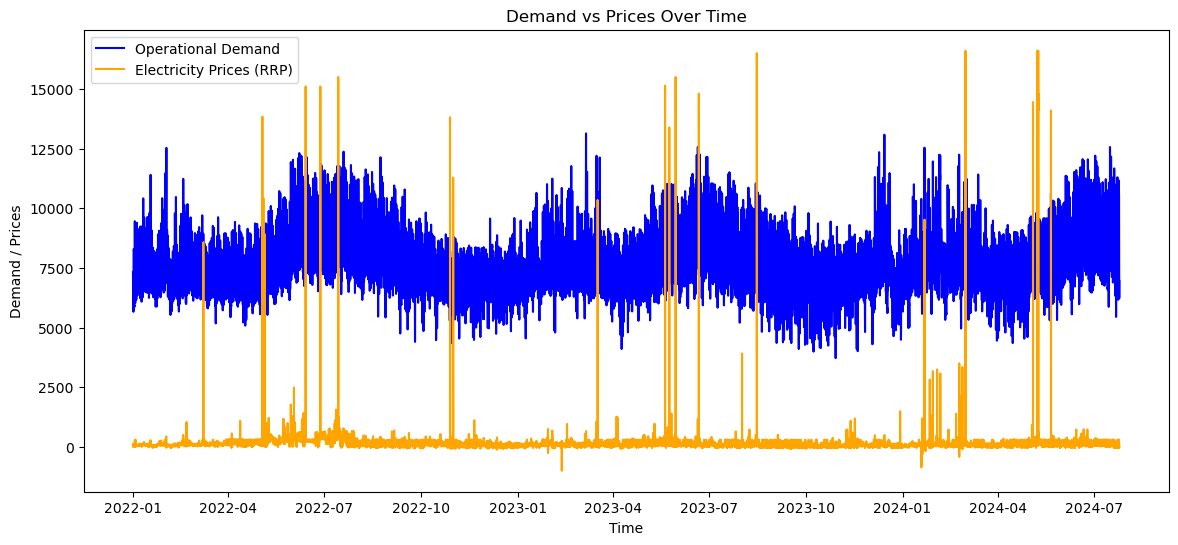

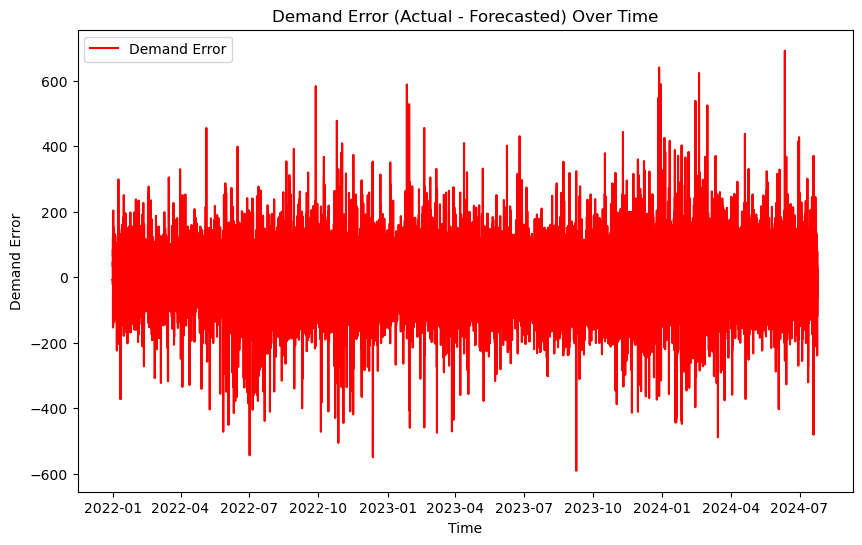

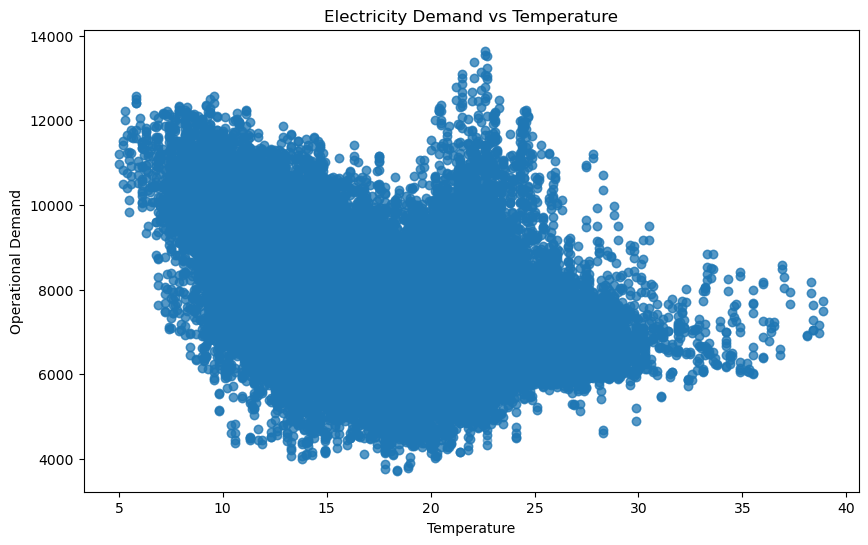

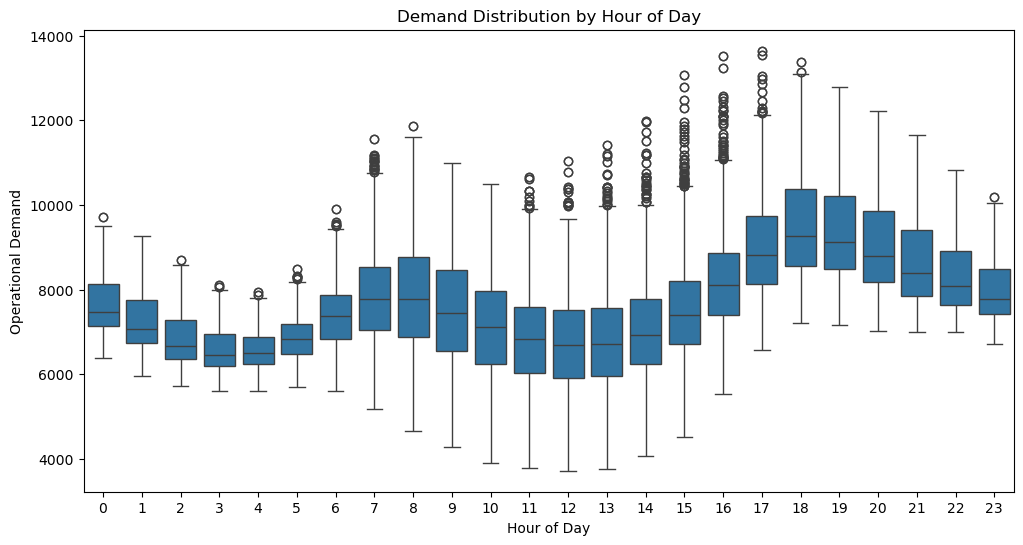

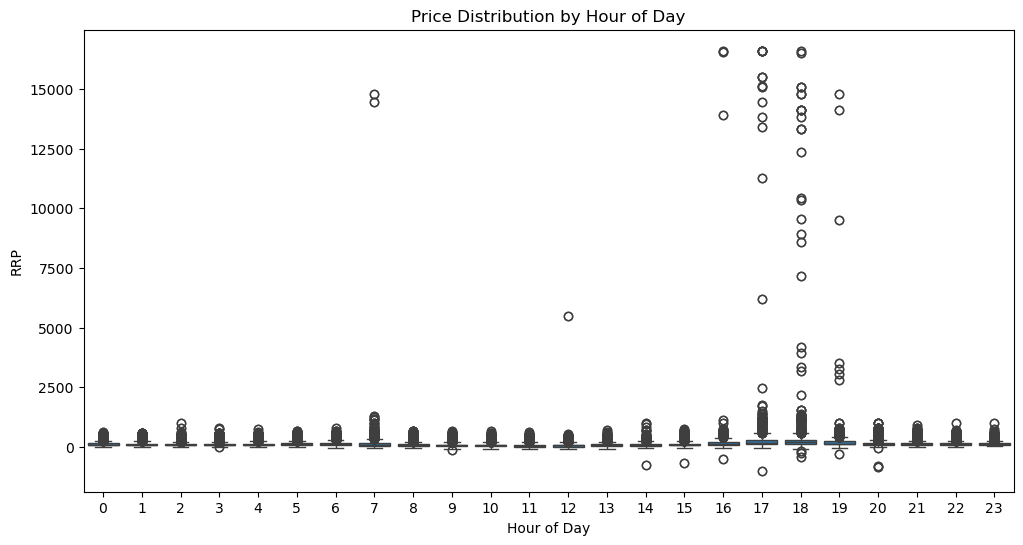

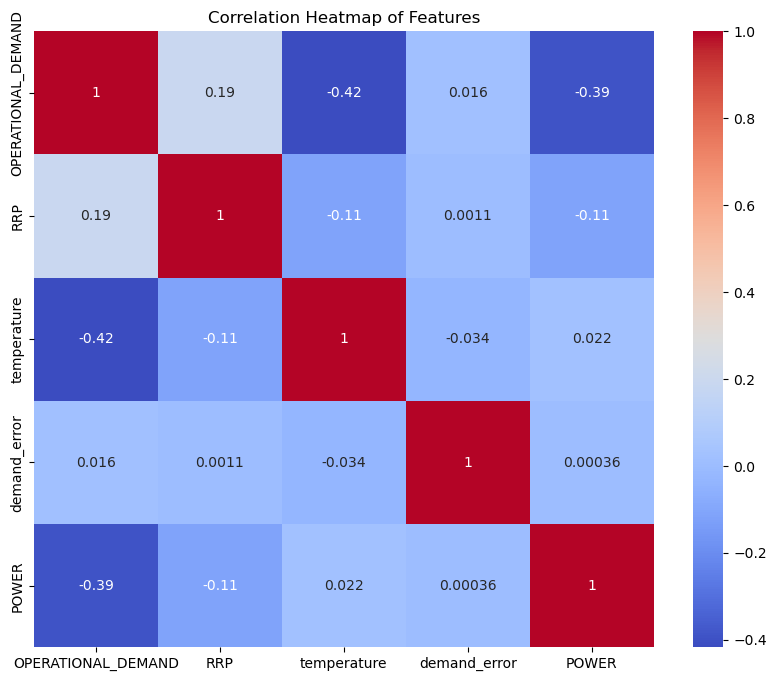

In [10]:
### Feature Engineering
# Calculate the demand error
merged_data['demand_error'] = merged_data['OPERATIONAL_DEMAND'] - merged_data['OPERATIONAL_DEMAND_POE50']

# Create lagged features (lagging by 1 interval)
merged_data['lagged_demand'] = merged_data['OPERATIONAL_DEMAND'].shift(1)
merged_data['lagged_RRP'] = merged_data['RRP'].shift(1)

# Extract day of the week and hour of the day
merged_data['day_of_week'] = pd.to_datetime(merged_data['date_time']).dt.dayofweek
merged_data['hour_of_day'] = pd.to_datetime(merged_data['date_time']).dt.hour
print(merged_data.head())

# plotting demand and prices over time
plt.figure(figsize=(14,6))
plt.plot(merged_data['date_time'], merged_data['OPERATIONAL_DEMAND'], label='Operational Demand', color='blue')
plt.plot(merged_data['date_time'], merged_data['RRP'], label='Electricity Prices (RRP)', color='orange')
plt.title('Demand vs Prices Over Time')
plt.xlabel('Time')
plt.ylabel('Demand / Prices')
plt.legend()
plt.show()

# plotting demand error
plt.figure(figsize=(10,6))
plt.plot(merged_data['date_time'], merged_data['demand_error'], label='Demand Error', color='red')
plt.title('Demand Error (Actual - Forecasted) Over Time')
plt.xlabel('Time')
plt.ylabel('Demand Error')
plt.legend()
plt.show()

# plotting electricity demand against temperature
plt.figure(figsize=(10,6))
plt.scatter(merged_data['temperature'], merged_data['OPERATIONAL_DEMAND'], alpha=0.5)
plt.title('Electricity Demand vs Temperature')
plt.xlabel('Temperature')
plt.ylabel('Operational Demand')
plt.show()

# plotting Distribution of Demand and Price Spikes based on the time of day
plt.figure(figsize=(12,6))
sns.boxplot(x='hour_of_day', y='OPERATIONAL_DEMAND', data=merged_data)
plt.title('Demand Distribution by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Operational Demand')
plt.show()

# plotting Distribution of Prices by Hour of Day
plt.figure(figsize=(12,6))
sns.boxplot(x='hour_of_day', y='RRP', data=merged_data)
plt.title('Price Distribution by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('RRP')
plt.show()

# RF

In [11]:
merged_data['lagged_demand'] = merged_data['lagged_demand'].fillna(0)
merged_data['lagged_RRP'] = merged_data['lagged_RRP'].fillna(0)
print(merged_data.isnull().sum())

date_time                   0
OPERATIONAL_DEMAND          0
RRP                         0
TYPE                        0
POWER                       0
OPERATIONAL_DEMAND_POE10    0
OPERATIONAL_DEMAND_POE50    0
OPERATIONAL_DEMAND_POE90    0
temperature                 0
demand_error                0
lagged_demand               0
lagged_RRP                  0
day_of_week                 0
hour_of_day                 0
dtype: int64


In [12]:


# Select features and target
features = ['OPERATIONAL_DEMAND', 'demand_error', 'lagged_demand', 'POWER', 'day_of_week', 'hour_of_day', 'temperature']
target = 'RRP'  # Target variable is the electricity price

X = merged_data[features].fillna(0)  # Fill any missing values with 0
y = merged_data[target].fillna(0)    # Fill missing target values with 0

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scale the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [13]:
# price spike as a percentage increase of 20% over a short period
merged_data['price_change_pct'] = merged_data['RRP'].pct_change() * 100
merged_data['price_spike'] = (merged_data['price_change_pct'] > 20).astype(int)  # Binary flag for price spikes
print(merged_data['price_spike'].value_counts())

price_spike
0    81488
1     8267
Name: count, dtype: int64


              precision    recall  f1-score   support

           0       0.90      1.00      0.94     16029
           1       0.55      0.04      0.07      1922

    accuracy                           0.89     17951
   macro avg       0.72      0.52      0.51     17951
weighted avg       0.86      0.89      0.85     17951



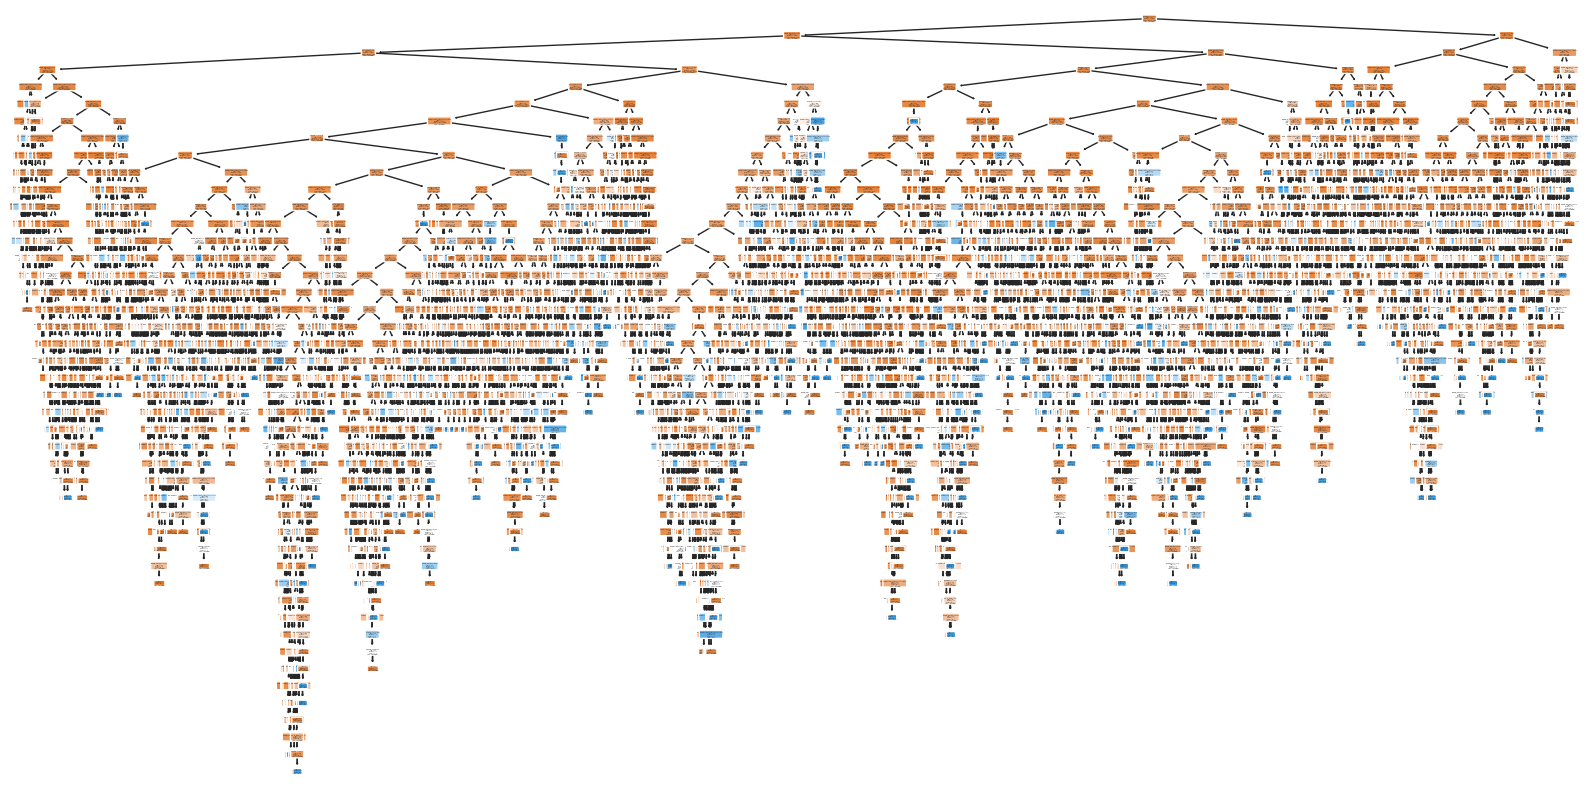

In [14]:
X_spike = merged_data[features].fillna(0)
y_spike = merged_data['price_spike'].fillna(0)
X_train_spike, X_test_spike, y_train_spike, y_test_spike = train_test_split(X_spike, y_spike, test_size=0.2, shuffle=False)

spike_model = RandomForestClassifier(n_estimators=100, random_state=42)
spike_model.fit(X_train_spike, y_train_spike)

y_pred_spike = spike_model.predict(X_test_spike)

print(classification_report(y_test_spike, y_pred_spike))



# Apply a Seaborn style for aesthetics
sns.set(style="whitegrid")

# Select the first tree from the random forest
first_tree = spike_model.estimators_[0]

# Plot the first decision tree
plt.figure(figsize=(20, 10))
plot_tree(first_tree, feature_names=features, filled=True, rounded=True, class_names=["No Spike", "Spike"])

# Show the plot
plt.show()

Feature Importance Rankings:
              Feature  Importance
2       lagged_demand    0.260902
0  OPERATIONAL_DEMAND    0.190131
3               POWER    0.170170
1        demand_error    0.143522
6         temperature    0.124909
5         hour_of_day    0.056436
4         day_of_week    0.053929


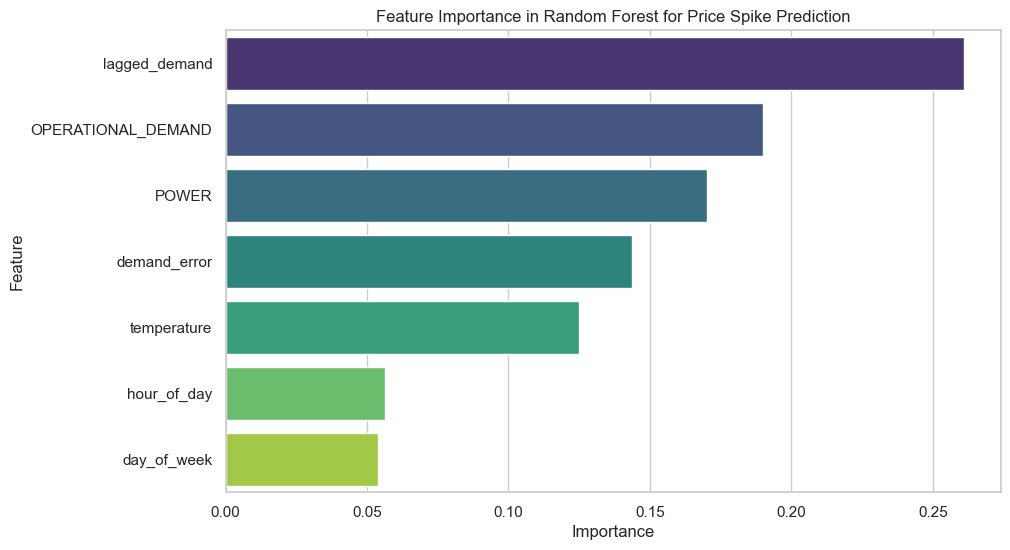

In [49]:
import numpy as np
import pandas as pd

# Get the feature importance scores
feature_importances = spike_model.feature_importances_

# Create a DataFrame to store the features and their importance
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort the DataFrame by importance (highest importance first)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance rankings
print("Feature Importance Rankings:")
print(feature_importance_df)

# Optionally, visualize the feature importances using a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance in Random Forest for Price Spike Prediction')
plt.show()


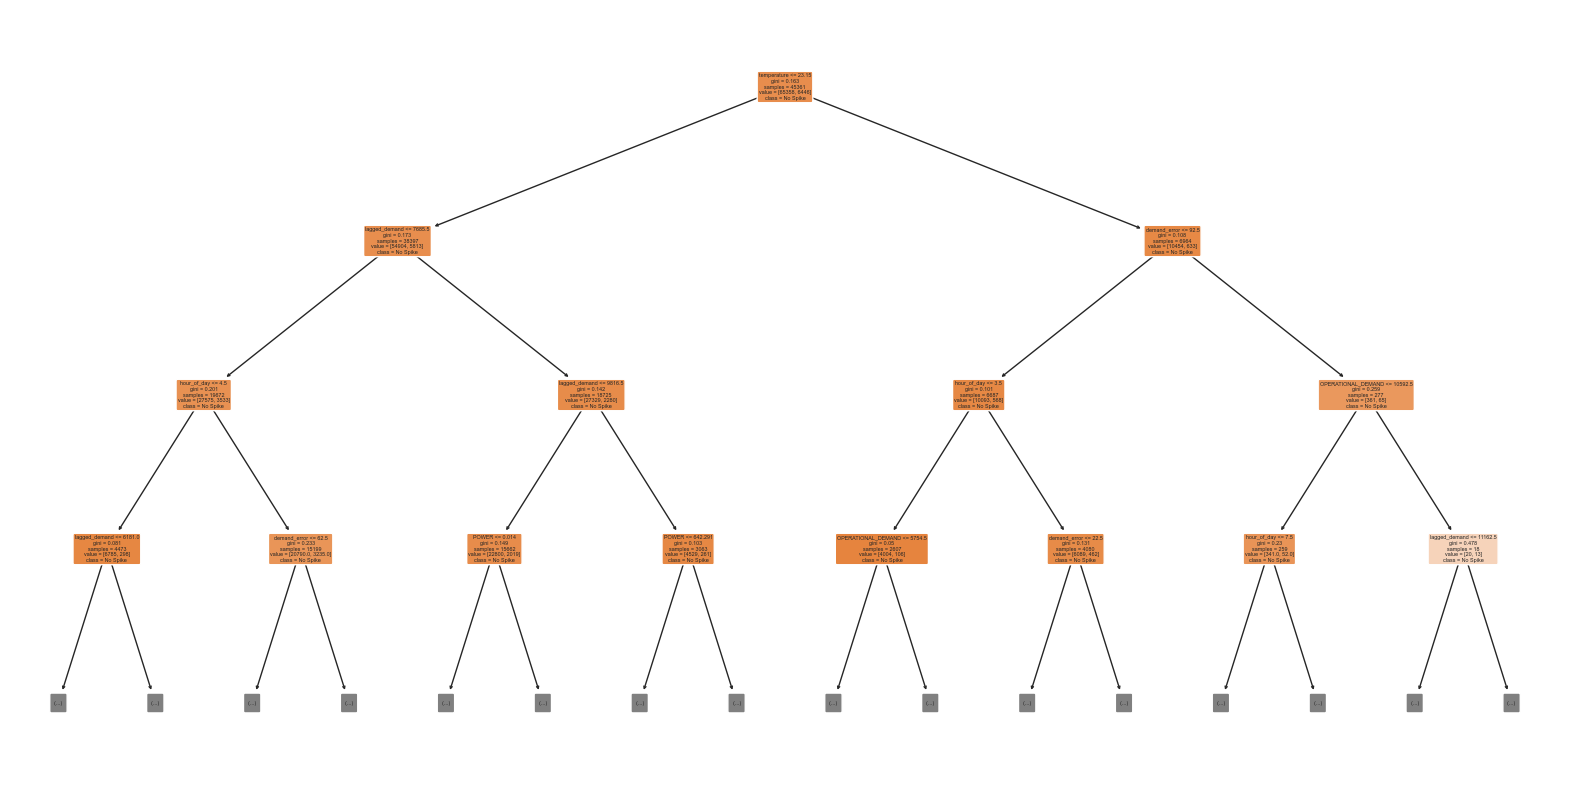

In [15]:
plt.figure(figsize=(20, 10))
plot_tree(first_tree, feature_names=features, filled=True, rounded=True, class_names=["No Spike", "Spike"], max_depth=3)
plt.show()

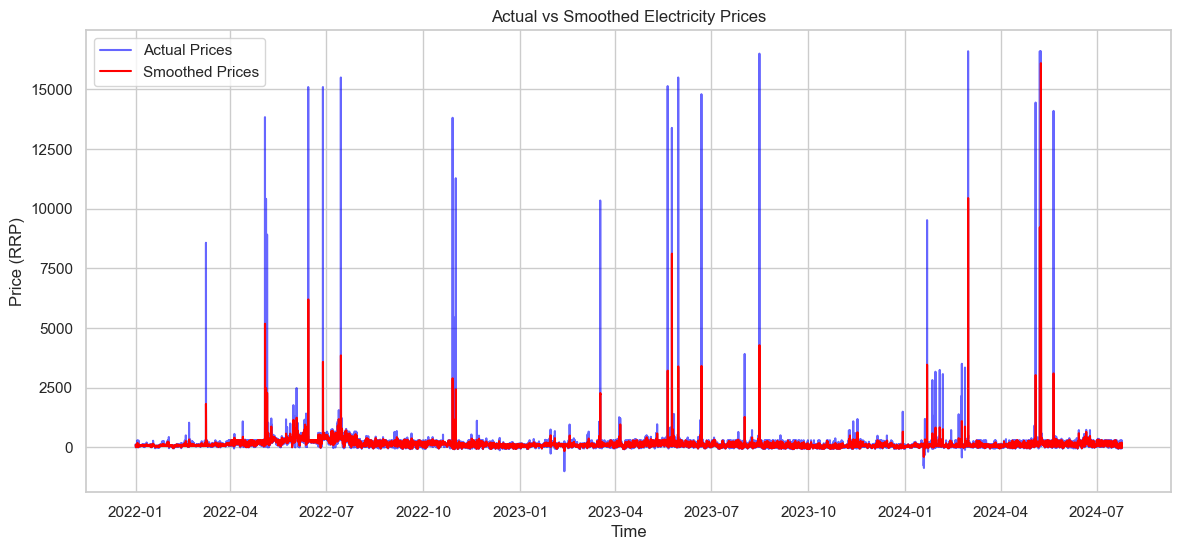

In [16]:
# Apply a rolling average to smooth the actual prices (RRP)
merged_data['RRP_smoothed'] = merged_data['RRP'].rolling(window=10).mean()

# Visualize the smoothed prices vs actual prices
plt.figure(figsize=(14,6))
plt.plot(merged_data['date_time'], merged_data['RRP'], label='Actual Prices', color='blue', alpha=0.6)
plt.plot(merged_data['date_time'], merged_data['RRP_smoothed'], label='Smoothed Prices', color='red')
plt.title('Actual vs Smoothed Electricity Prices')
plt.xlabel('Time')
plt.ylabel('Price (RRP)')
plt.legend()
plt.show()

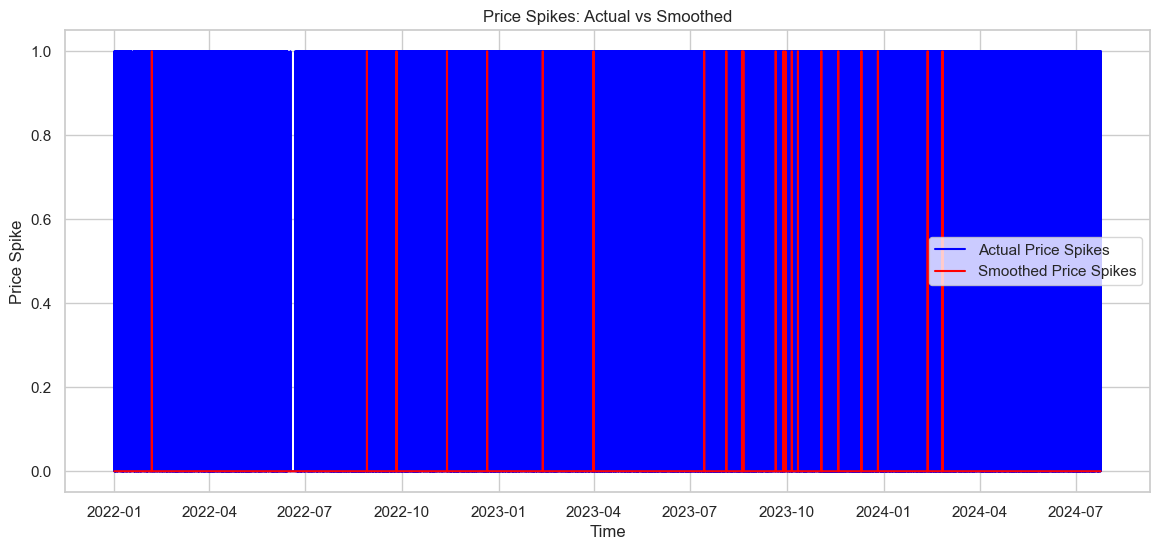

In [17]:
# Identify spikes in the smoothed data
merged_data['price_spike_smoothed'] = (merged_data['RRP_smoothed'].pct_change() > 20).astype(int)

# Visualize the actual and smoothed spikes
plt.figure(figsize=(14,6))
plt.plot(merged_data['date_time'], merged_data['price_spike'], label='Actual Price Spikes', color='blue')
plt.plot(merged_data['date_time'], merged_data['price_spike_smoothed'], label='Smoothed Price Spikes', color='red')
plt.title('Price Spikes: Actual vs Smoothed')
plt.xlabel('Time')
plt.ylabel('Price Spike')
plt.legend()
plt.show()

# LSTM

In [18]:
# LSTM

Epoch 1/20
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8933 - loss: 0.3352 - val_accuracy: 0.9065 - val_loss: 0.2971
Epoch 2/20
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9102 - loss: 0.2905 - val_accuracy: 0.9065 - val_loss: 0.3003
Epoch 3/20
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9077 - loss: 0.2947 - val_accuracy: 0.9065 - val_loss: 0.2962
Epoch 4/20
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9076 - loss: 0.2943 - val_accuracy: 0.9065 - val_loss: 0.2940
Epoch 5/20
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9095 - loss: 0.2892 - val_accuracy: 0.9065 - val_loss: 0.2929
Epoch 6/20
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9081 - loss: 0.2920 - val_accuracy: 0.9065 - val_loss: 0.2924
Epoch 7/20
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9075 - loss: 0.2919 - val_accuracy: 0.9065 - val_loss: 0.2949
Epoch 8/20
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9096 - loss: 0.2868

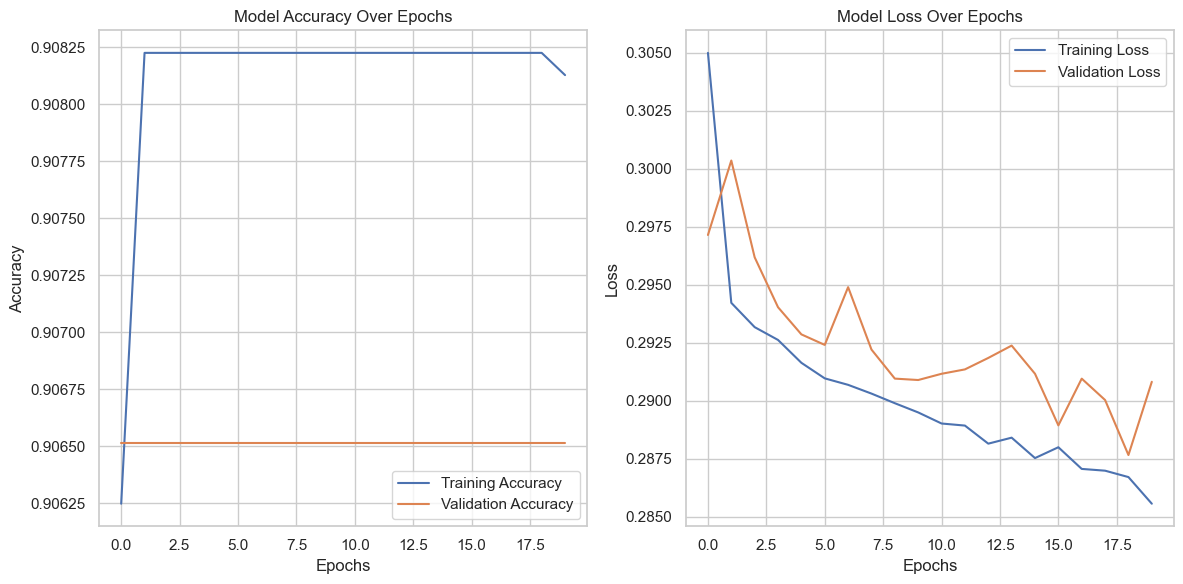

561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


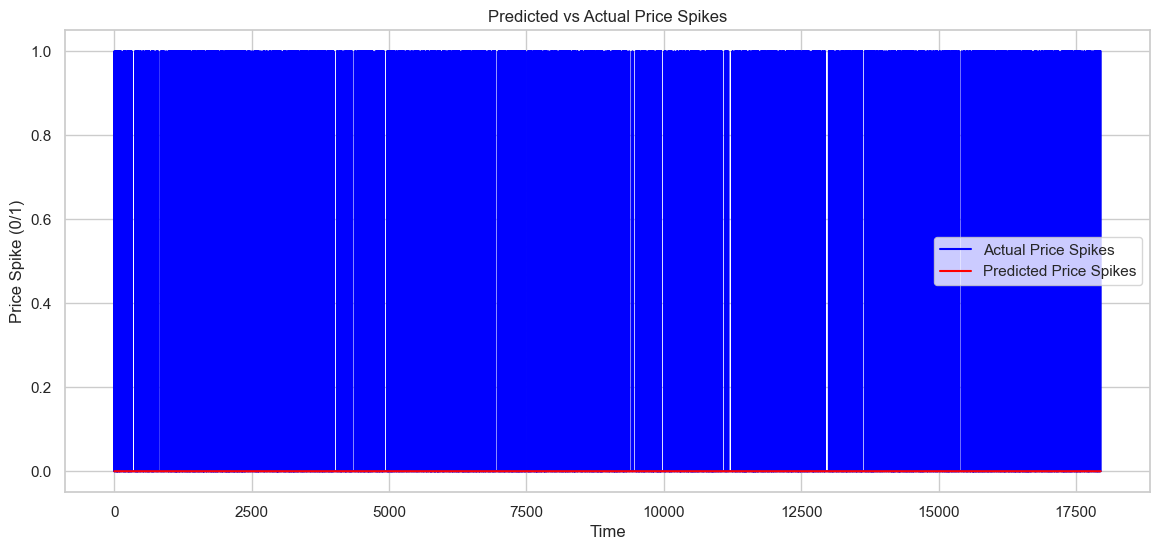

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Step 1: Load and preprocess the data
# Assuming you already merged the relevant datasets as merged_data

# Features: Use your selected features here
features = ['OPERATIONAL_DEMAND', 'demand_error', 'lagged_demand', 'POWER', 'day_of_week', 'hour_of_day', 'temperature']
target = 'price_spike'  # Predicting price spike (binary classification)

# Prepare features (X) and target (y)
X = merged_data[features].fillna(0)
y = merged_data[target].fillna(0)

# Step 2: Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Create sequences for LSTM (e.g., 10 timesteps)
def create_lstm_sequences(X, y, n_steps):
    X_seq, y_seq = [], []
    for i in range(len(X) - n_steps):
        X_seq.append(X[i:i + n_steps])
        y_seq.append(y[i + n_steps])
    return np.array(X_seq), np.array(y_seq)

n_steps = 10  # Number of time steps in each sequence
X_seq, y_seq = create_lstm_sequences(X_scaled, y, n_steps)

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=True)

# Step 5: Build the LSTM + RNN Model
model = tf.keras.Sequential()

# First LSTM layer
model.add(tf.keras.layers.LSTM(128, activation='relu', return_sequences=True, input_shape=(n_steps, X_train.shape[2])))

# Second LSTM layer
model.add(tf.keras.layers.LSTM(64, activation='relu', return_sequences=True))

# Dropout layer to prevent overfitting
model.add(tf.keras.layers.Dropout(0.3))

# Simple RNN layer for further sequence processing
model.add(tf.keras.layers.SimpleRNN(32, activation='relu'))

# Output layer (binary classification: spike or no spike)
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Step 6: Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 7: Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

# Step 8: Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Step 9: Plot training and validation accuracy and loss over epochs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Step 10: Make predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Threshold at 0.5 for binary classification

# Step 11: Visualize predicted vs actual price spikes
plt.figure(figsize=(14,6))
plt.plot(y_test, label='Actual Price Spikes', color='blue')
plt.plot(y_pred, label='Predicted Price Spikes', color='red')
plt.title('Predicted vs Actual Price Spikes')
plt.xlabel('Time')
plt.ylabel('Price Spike (0/1)')
plt.legend()
plt.show()

In [48]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 10, 128)        │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 366,533 (1.40 MB)

 Trainable params: 122,177 (477.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 244,356 (954.52 KB)

# Smoothing using gaussian_filter1d

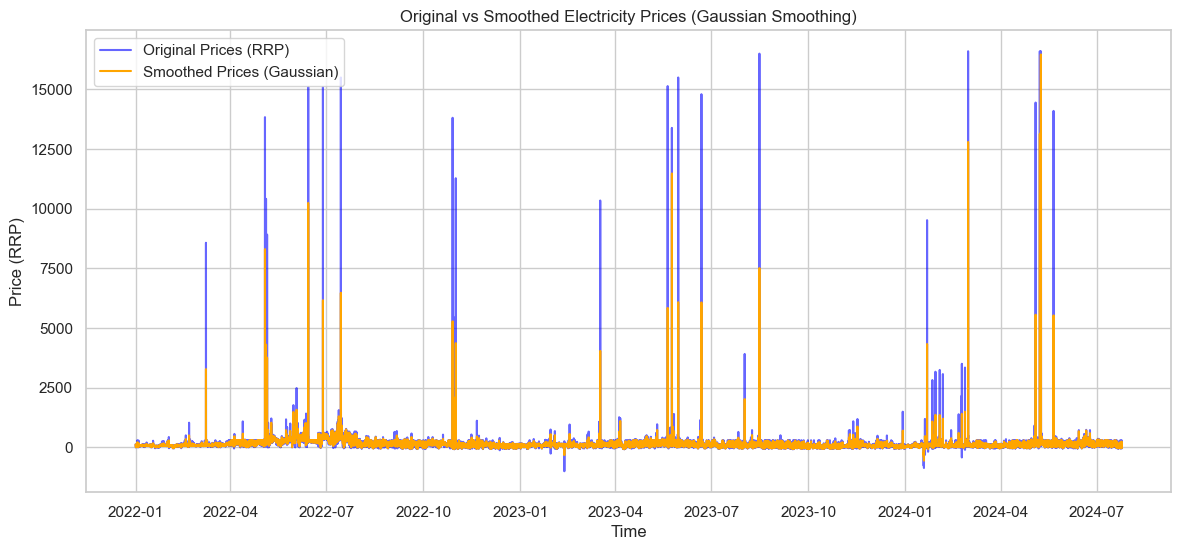

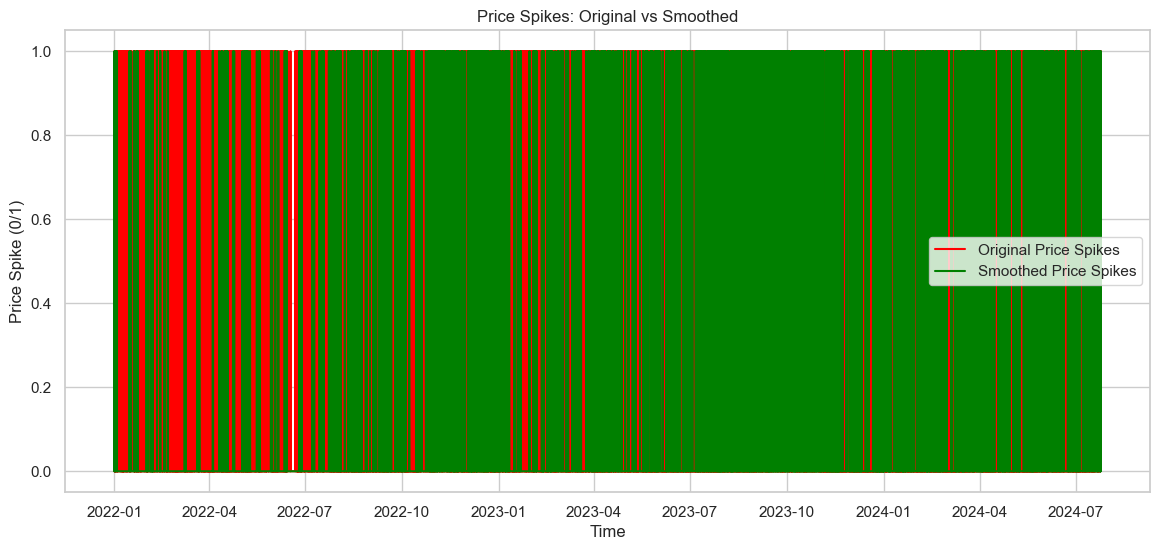

Number of Original Price Spikes: 8267
Number of Smoothed Price Spikes: 4243


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Step 1: Load the data (assuming the merged dataset 'merged_data' is already prepared)
# Apply Gaussian smoothing with a sigma of 2 to the 'RRP' column (electricity price)
merged_data['RRP_gaussian_smoothed'] = gaussian_filter1d(merged_data['RRP'], sigma=2)

# Step 2: Visualize the original vs smoothed prices
plt.figure(figsize=(14,6))
plt.plot(merged_data['date_time'], merged_data['RRP'], label='Original Prices (RRP)', color='blue', alpha=0.6)
plt.plot(merged_data['date_time'], merged_data['RRP_gaussian_smoothed'], label='Smoothed Prices (Gaussian)', color='orange')
plt.title('Original vs Smoothed Electricity Prices (Gaussian Smoothing)')
plt.xlabel('Time')
plt.ylabel('Price (RRP)')
plt.legend()
plt.show()

# Step 3: Compare price spikes before and after smoothing
# Define a price spike as a 20% increase within a short window
merged_data['price_spike_original'] = (merged_data['RRP'].pct_change() > 0.2).astype(int)
merged_data['price_spike_smoothed'] = (merged_data['RRP_gaussian_smoothed'].pct_change() > 0.2).astype(int)

# Visualize the original vs smoothed price spikes
plt.figure(figsize=(14,6))
plt.plot(merged_data['date_time'], merged_data['price_spike_original'], label='Original Price Spikes', color='red')
plt.plot(merged_data['date_time'], merged_data['price_spike_smoothed'], label='Smoothed Price Spikes', color='green')
plt.title('Price Spikes: Original vs Smoothed')
plt.xlabel('Time')
plt.ylabel('Price Spike (0/1)')
plt.legend()
plt.show()

# Step 4: Count the number of price spikes before and after smoothing
original_spike_count = merged_data['price_spike_original'].sum()
smoothed_spike_count = merged_data['price_spike_smoothed'].sum()

print(f"Number of Original Price Spikes: {original_spike_count}")
print(f"Number of Smoothed Price Spikes: {smoothed_spike_count}")

# Model eval

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Step 1: Calculate RMSE and MAE for original prices
rmse_original = np.sqrt(mean_squared_error(merged_data['RRP'], merged_data['RRP_gaussian_smoothed']))
mae_original = mean_absolute_error(merged_data['RRP'], merged_data['RRP_gaussian_smoothed'])

print(f"RMSE (Original vs Smoothed): {rmse_original}")
print(f"MAE (Original vs Smoothed): {mae_original}")

# Step 2: Compare the variance and standard deviation of the original and smoothed prices
variance_original = np.var(merged_data['RRP'])
variance_smoothed = np.var(merged_data['RRP_gaussian_smoothed'])
std_dev_original = np.std(merged_data['RRP'])
std_dev_smoothed = np.std(merged_data['RRP_gaussian_smoothed'])

print(f"Variance (Original Prices): {variance_original}")
print(f"Variance (Smoothed Prices): {variance_smoothed}")
print(f"Standard Deviation (Original Prices): {std_dev_original}")
print(f"Standard Deviation (Smoothed Prices): {std_dev_smoothed}")


RMSE (Original vs Smoothed): 214.25768802892085
MAE (Original vs Smoothed): 23.473526483191765
Variance (Original Prices): 184873.92946849475
Variance (Smoothed Prices): 108142.42862812725
Standard Deviation (Original Prices): 429.96968435983337
Standard Deviation (Smoothed Prices): 328.85016136247714


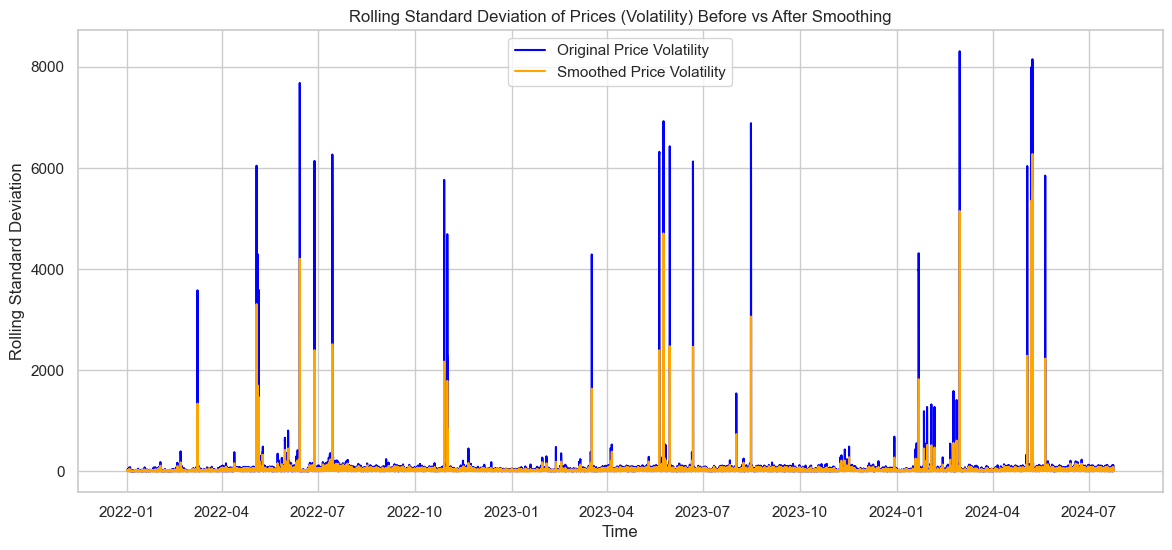

In [22]:
# Step 3: Visualize rolling standard deviation of prices
window_size = 10  # Use a window size of 10 to calculate rolling standard deviation

merged_data['rolling_std_original'] = merged_data['RRP'].rolling(window=window_size).std()
merged_data['rolling_std_smoothed'] = merged_data['RRP_gaussian_smoothed'].rolling(window=window_size).std()

# Plot the rolling standard deviation (volatility) before and after smoothing
plt.figure(figsize=(14,6))
plt.plot(merged_data['date_time'], merged_data['rolling_std_original'], label='Original Price Volatility', color='blue')
plt.plot(merged_data['date_time'], merged_data['rolling_std_smoothed'], label='Smoothed Price Volatility', color='orange')
plt.title('Rolling Standard Deviation of Prices (Volatility) Before vs After Smoothing')
plt.xlabel('Time')
plt.ylabel('Rolling Standard Deviation')
plt.legend()
plt.show()

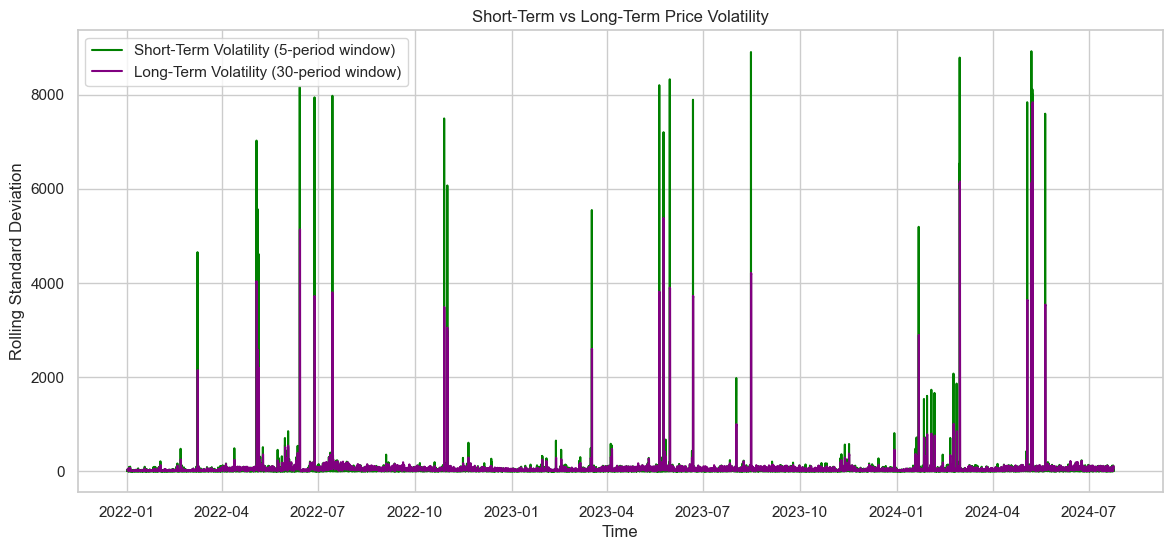

In [23]:
# Try different window sizes
window_size_small = 5  # Shorter-term view of volatility
window_size_large = 30  # Longer-term view of volatility

# Calculate rolling standard deviations with different window sizes
merged_data['rolling_std_small'] = merged_data['RRP'].rolling(window=window_size_small).std()
merged_data['rolling_std_large'] = merged_data['RRP'].rolling(window=window_size_large).std()

# Plot for comparison
plt.figure(figsize=(14,6))
plt.plot(merged_data['date_time'], merged_data['rolling_std_small'], label='Short-Term Volatility (5-period window)', color='green')
plt.plot(merged_data['date_time'], merged_data['rolling_std_large'], label='Long-Term Volatility (30-period window)', color='purple')
plt.title('Short-Term vs Long-Term Price Volatility')
plt.xlabel('Time')
plt.ylabel('Rolling Standard Deviation')
plt.legend()
plt.show()


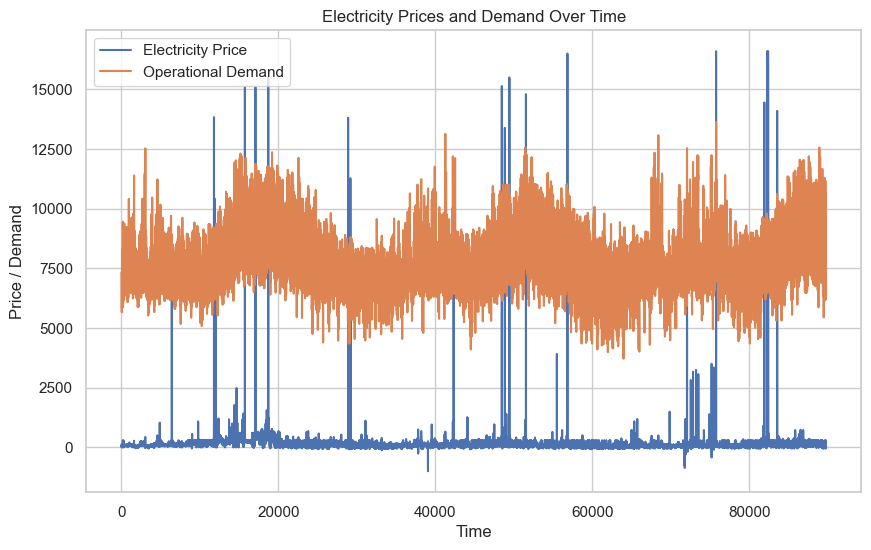

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(merged_data['RRP'], label='Electricity Price')
plt.plot(merged_data['OPERATIONAL_DEMAND'], label='Operational Demand')
plt.title('Electricity Prices and Demand Over Time')
plt.xlabel('Time')
plt.ylabel('Price / Demand')
plt.legend()
plt.show()


In [26]:
# peak_demand = merged_data[merged_data['OPERATIONAL_DEMAND'] > threshold_demand]

# plt.figure(figsize=(10, 6))
# plt.plot(merged_data['OPERATIONAL_DEMAND'], label='Operational Demand')
# plt.scatter(peak_demand.index, peak_demand['OPERATIONAL_DEMAND'], color='red', label='Peak Demand', zorder=5)
# plt.title('Peak Demand Periods')
# plt.xlabel('Time')
# plt.ylabel('Operational Demand')
# plt.legend()
# plt.show()


In [28]:
# plt.figure(figsize=(10, 6))
# plt.plot(y_test, label='Actual Prices', color='blue')
# plt.plot(y_pred, label='Predicted Prices', color='red', linestyle='--')
# plt.title('Actual vs Predicted Electricity Prices')
# plt.xlabel('Time')
# plt.ylabel('Price')
# plt.legend()
# plt.show()


# Seasonal smoothening

In [29]:
# Define a function to assign seasons based on the month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Summer'
    elif month in [3, 4, 5]:
        return 'Autumn'
    elif month in [6, 7, 8]:
        return 'Winter'
    elif month in [9, 10, 11]:
        return 'Spring'

# Add a 'season' column based on the 'date_time' month
merged_data['month'] = merged_data['date_time'].dt.month
merged_data['season'] = merged_data['month'].apply(get_season)

# Split data into seasonal datasets
summer_data = merged_data[merged_data['season'] == 'Summer']
autumn_data = merged_data[merged_data['season'] == 'Autumn']
winter_data = merged_data[merged_data['season'] == 'Winter']
spring_data = merged_data[merged_data['season'] == 'Spring']


In [30]:
summer_data.isnull().sum()

date_time                     0
OPERATIONAL_DEMAND            0
RRP                           0
TYPE                          0
POWER                         0
OPERATIONAL_DEMAND_POE10      0
OPERATIONAL_DEMAND_POE50      0
OPERATIONAL_DEMAND_POE90      0
temperature                   0
demand_error                  0
lagged_demand                 0
lagged_RRP                    0
day_of_week                   0
hour_of_day                   0
price_change_pct            109
price_spike                   0
RRP_smoothed                  9
price_spike_smoothed          0
RRP_gaussian_smoothed         0
price_spike_original          0
rolling_std_original          9
rolling_std_smoothed          9
rolling_std_small             4
rolling_std_large            29
month                         0
season                        0
dtype: int64

In [38]:
# Fill missing values for price_change_pct with 0 (no change)
season_data['price_change_pct'].fillna(0, inplace=True)

# Forward-fill or backward-fill missing values in smoothed columns
season_data['RRP_smoothed'].fillna(method='ffill', inplace=True)
season_data['rolling_std_original'].fillna(method='ffill', inplace=True)
season_data['rolling_std_smoothed'].fillna(method='ffill', inplace=True)
season_data['rolling_std_small'].fillna(method='ffill', inplace=True)
season_data['rolling_std_large'].fillna(method='ffill', inplace=True)

# Optionally, you can use backward-fill if forward-fill leaves too many NaNs at the beginning
season_data.fillna(method='bfill', inplace=True)


## Summer season

In [40]:
def create_lstm_sequences(X, y, n_steps):
    X_seq, y_seq = [], []
    for i in range(len(X) - n_steps):
        X_seq.append(X[i:i + n_steps])
        # Ensure we are within the bounds of y
        if i + n_steps < len(y):
            y_seq.append(y[i + n_steps])
        else:
            break  # Avoid accessing out-of-bounds in y
    return np.array(X_seq), np.array(y_seq)


Epoch 1/20
575/575 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9073 - loss: 0.3202 - val_accuracy: 0.8943 - val_loss: 0.3456
Epoch 2/20
575/575 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9141 - loss: 0.2822 - val_accuracy: 0.8943 - val_loss: 0.3342
Epoch 3/20
575/575 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9172 - loss: 0.2745 - val_accuracy: 0.8943 - val_loss: 0.3579
Epoch 4/20
575/575 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9176 - loss: 0.2710 - val_accuracy: 0.8943 - val_loss: 0.3325
Epoch 5/20
575/575 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9138 - loss: 0.2815 - val_accuracy: 0.8943 - val_loss: 0.3289
Epoch 6/20
575/575 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9197 - loss: 0.2657 - val_accuracy: 0.8943 - val_loss: 0.3316
Epoch 7/20
575/575 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9211 - loss: 0.2631 - val_accuracy: 0.8943 - val_loss: 0.3378
Epoch 8/20
575/575 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9201 - loss: 0.2662 - val_accu

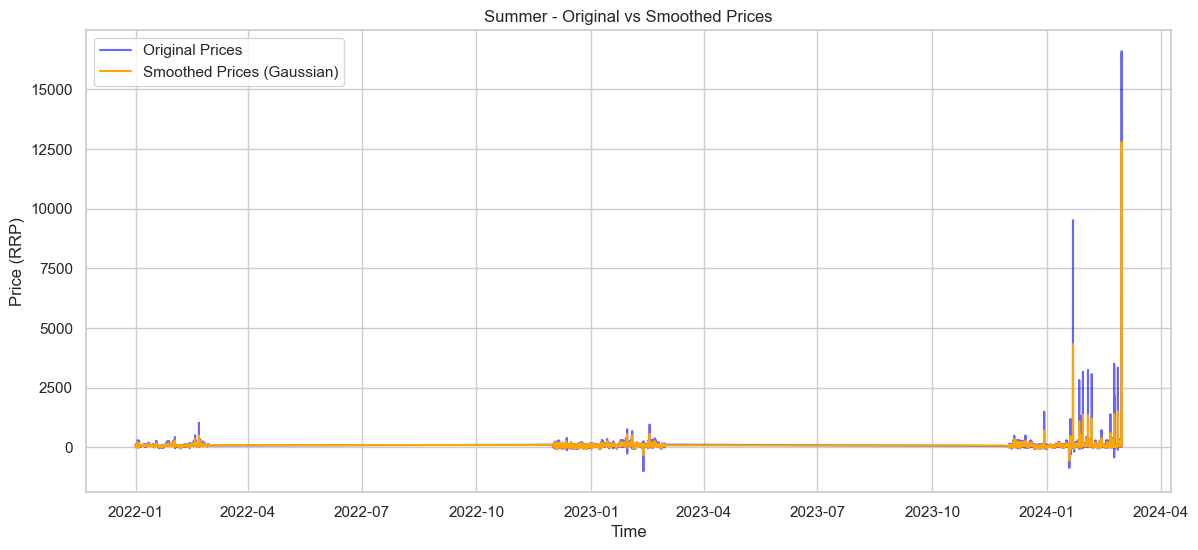

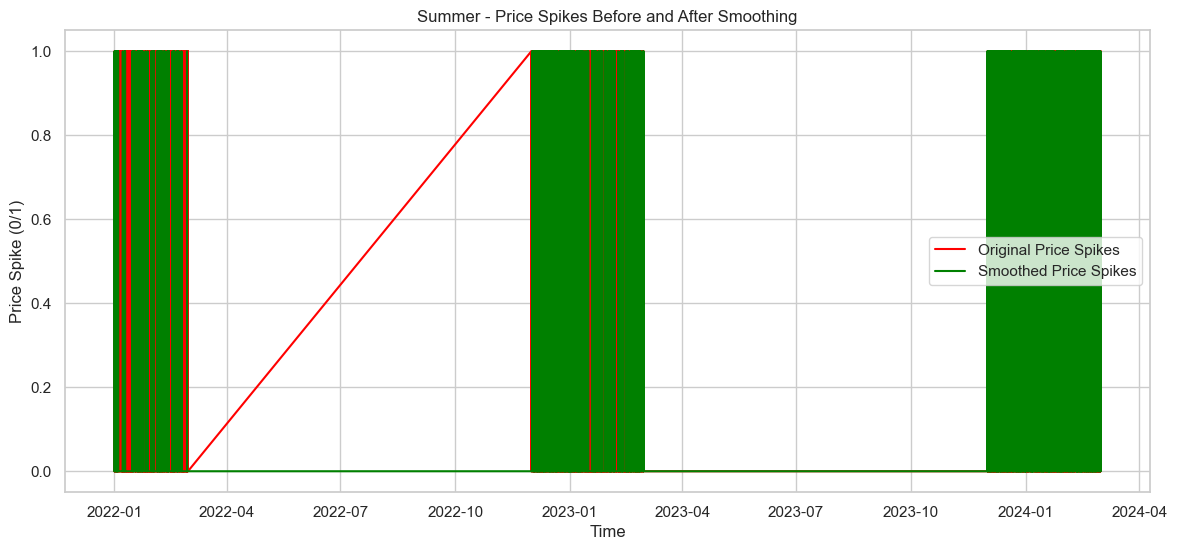

Summer - Original Spikes: 2898, Smoothed Spikes: 2161


In [41]:
# Use summer_data as an example, repeat this for each seasonal dataset
season_data = summer_data  # Replace with autumn_data, winter_data, spring_data accordingly

# Step 1: Preprocess the data (as done previously)
features = ['OPERATIONAL_DEMAND', 'demand_error', 'lagged_demand', 'POWER', 'day_of_week', 'hour_of_day', 'temperature']
target = 'price_spike'

# Prepare features and target
X = season_data[features].fillna(0)
y = season_data[target].fillna(0)

# Reset index for the y target values
y = y.reset_index(drop=True)

# Then proceed with the same sequence creation step
X_seq, y_seq = create_lstm_sequences(X_scaled, y, n_steps=10)

# Step 2: Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Create sequences for LSTM
X_seq, y_seq = create_lstm_sequences(X_scaled, y, n_steps=20)

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Step 5: Build and train the model (LSTM + RNN as defined earlier)
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, activation='relu', return_sequences=True, input_shape=(10, X_train.shape[2])))
model.add(tf.keras.layers.LSTM(64, activation='relu', return_sequences=True))
# model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.SimpleRNN(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # Binary classification (spike or no spike)

# Compile and train the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Step 6: Apply Gaussian smoothing (as done previously)
season_data['RRP_gaussian_smoothed'] = gaussian_filter1d(season_data['RRP'], sigma=2)

# Plot the original vs smoothed prices
plt.figure(figsize=(14,6))
plt.plot(season_data['date_time'], season_data['RRP'], label='Original Prices', color='blue', alpha=0.6)
plt.plot(season_data['date_time'], season_data['RRP_gaussian_smoothed'], label='Smoothed Prices (Gaussian)', color='orange')
plt.title(f'{season_data["season"].iloc[0]} - Original vs Smoothed Prices')
plt.xlabel('Time')
plt.ylabel('Price (RRP)')
plt.legend()
plt.show()

# Step 7: Analyze price spikes before and after smoothing
season_data['price_spike_original'] = (season_data['RRP'].pct_change() > 0.1).astype(int)
season_data['price_spike_smoothed'] = (season_data['RRP_gaussian_smoothed'].pct_change() > 0.1).astype(int)

# Compare spikes
plt.figure(figsize=(14,6))
plt.plot(season_data['date_time'], season_data['price_spike_original'], label='Original Price Spikes', color='red')
plt.plot(season_data['date_time'], season_data['price_spike_smoothed'], label='Smoothed Price Spikes', color='green')
plt.title(f'{season_data["season"].iloc[0]} - Price Spikes Before and After Smoothing')
plt.xlabel('Time')
plt.ylabel('Price Spike (0/1)')
plt.legend()
plt.show()

# Count the number of spikes before and after smoothing
original_spikes = season_data['price_spike_original'].sum()
smoothed_spikes = season_data['price_spike_smoothed'].sum()
print(f"{season_data['season'].iloc[0]} - Original Spikes: {original_spikes}, Smoothed Spikes: {smoothed_spikes}")


In [47]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 10, 128)        │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 366,533 (1.40 MB)

 Trainable params: 122,177 (477.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 244,356 (954.52 KB)

In [45]:
# import matplotlib.dates as mdates
# import pandas as pd

# # Ensure that the 'date_time' column is in datetime format
# season_data['date_time'] = pd.to_datetime(season_data['date_time'])

# # Step 1: Filter the data between 2021 and 2023
# filtered_data = season_data[(season_data['date_time'] >= '2021-01-01') & (season_data['date_time'] <= '2023-12-31')]

# # Step 2: Reindex the dataset to ensure continuous time series (assuming hourly data)
# filtered_data = filtered_data.set_index('date_time').asfreq('H')  # Hourly frequency
# filtered_data = filtered_data.interpolate()  # Fill in missing data with interpolation

# # Reset index after reindexing
# filtered_data = filtered_data.reset_index()

# # Step 3: Apply Gaussian smoothing (already done in your previous steps)
# filtered_data['RRP_gaussian_smoothed'] = gaussian_filter1d(filtered_data['RRP'], sigma=2)

# # Step 4: Plot Original vs Smoothed Prices for the period from 2021 to 2023
# plt.figure(figsize=(14, 6))

# # Adjust line style, color, and alpha for better visualization
# plt.plot(filtered_data['date_time'], filtered_data['RRP'], label='Original Prices', color='blue', alpha=0.4, linewidth=1)
# plt.plot(filtered_data['date_time'], filtered_data['RRP_gaussian_smoothed'], label='Smoothed Prices (Gaussian)', color='orange', linewidth=2)

# # Improve the title, labels, and legend
# plt.title('Original vs Smoothed Prices (2021 to 2023)')
# plt.xlabel('Time')
# plt.ylabel('Price (RRP)')
# plt.legend(loc='upper left')

# # Format x-axis labels to improve readability (show more frequent ticks)
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show ticks every 3 months
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# # Rotate the x-axis labels for better readability
# plt.xticks(rotation=45)

# plt.tight_layout()
# plt.show()


## Autumn

Epoch 1/20
662/662 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9004 - loss: 0.3309 - val_accuracy: 0.8820 - val_loss: 0.3499
Epoch 2/20
662/662 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9098 - loss: 0.2939 - val_accuracy: 0.8820 - val_loss: 0.3767
Epoch 3/20
662/662 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9093 - loss: 0.2901 - val_accuracy: 0.8820 - val_loss: 0.3953
Epoch 4/20
662/662 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9109 - loss: 0.2894 - val_accuracy: 0.8820 - val_loss: 0.3616
Epoch 5/20
662/662 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9120 - loss: 0.2836 - val_accuracy: 0.8820 - val_loss: 0.3471
Epoch 6/20
662/662 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9144 - loss: 0.2789 - val_accuracy: 0.8820 - val_loss: 0.3624
Epoch 7/20
662/662 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9108 - loss: 0.2849 - val_accuracy: 0.8820 - val_loss: 0.3492
Epoch 8/20
662/662 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9117 - loss: 0.2832 - val_accu

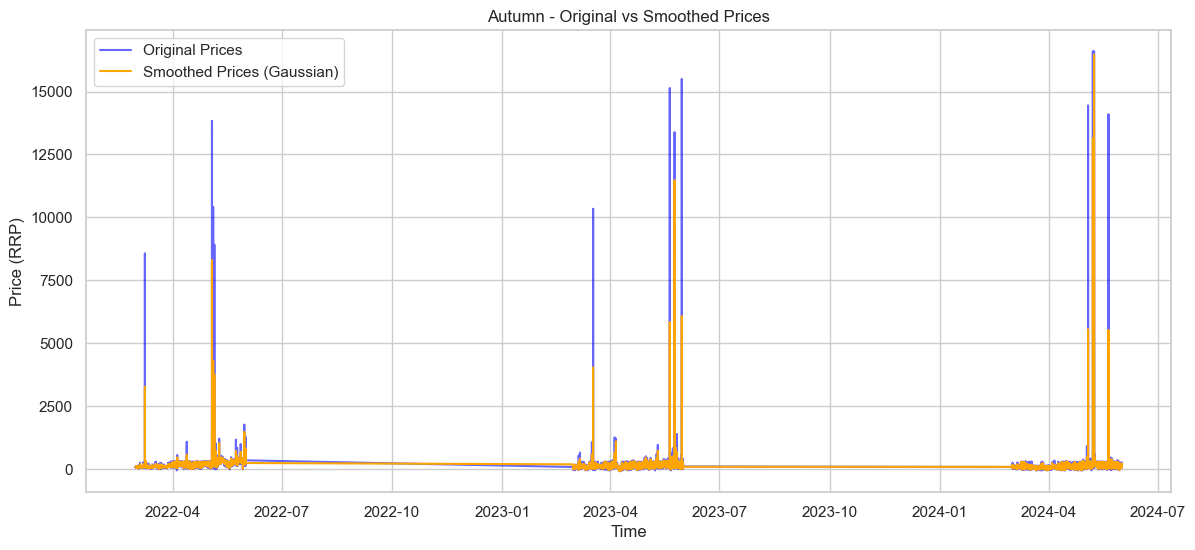

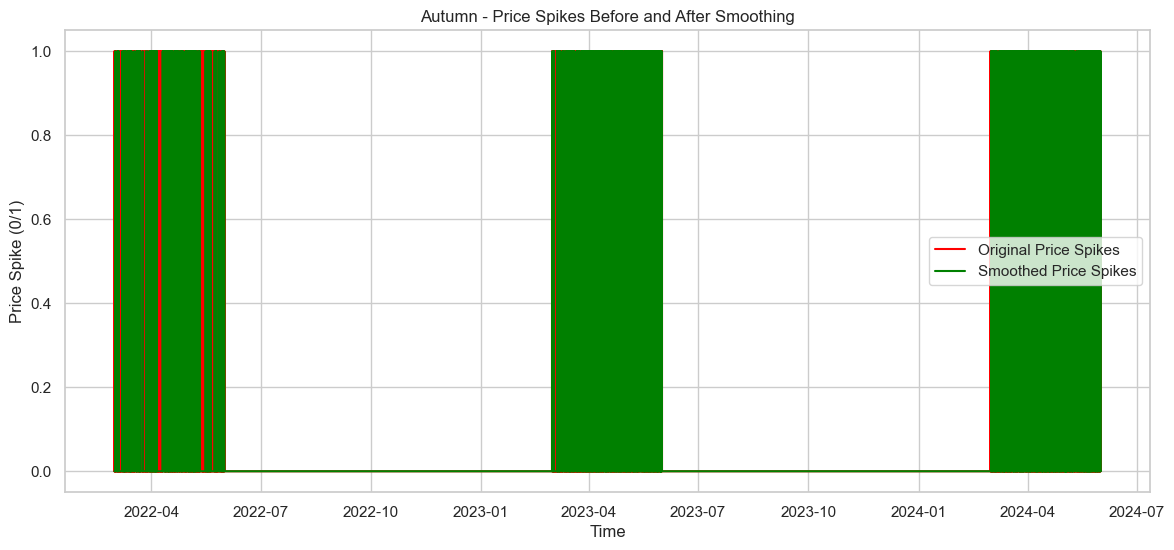

Autumn - Original Spikes: 3537, Smoothed Spikes: 2634


In [46]:
# Use summer_data as an example, repeat this for each seasonal dataset
season_data = autumn_data  # Replace with autumn_data, winter_data, spring_data accordingly

# Step 1: Preprocess the data (as done previously)
features = ['OPERATIONAL_DEMAND', 'demand_error', 'lagged_demand', 'POWER', 'day_of_week', 'hour_of_day', 'temperature']
target = 'price_spike'

# Prepare features and target
X = season_data[features].fillna(0)
y = season_data[target].fillna(0)

# Reset index for the y target values
y = y.reset_index(drop=True)

# Then proceed with the same sequence creation step
X_seq, y_seq = create_lstm_sequences(X_scaled, y, n_steps=10)

# Step 2: Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Create sequences for LSTM
X_seq, y_seq = create_lstm_sequences(X_scaled, y, n_steps=20)

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Step 5: Build and train the model (LSTM + RNN as defined earlier)
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, activation='relu', return_sequences=True, input_shape=(10, X_train.shape[2])))
model.add(tf.keras.layers.LSTM(64, activation='relu', return_sequences=True))
# model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.SimpleRNN(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # Binary classification (spike or no spike)

# Compile and train the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Step 6: Apply Gaussian smoothing (as done previously)
season_data['RRP_gaussian_smoothed'] = gaussian_filter1d(season_data['RRP'], sigma=2)

# Plot the original vs smoothed prices
plt.figure(figsize=(14,6))
plt.plot(season_data['date_time'], season_data['RRP'], label='Original Prices', color='blue', alpha=0.6)
plt.plot(season_data['date_time'], season_data['RRP_gaussian_smoothed'], label='Smoothed Prices (Gaussian)', color='orange')
plt.title(f'{season_data["season"].iloc[0]} - Original vs Smoothed Prices')
plt.xlabel('Time')
plt.ylabel('Price (RRP)')
plt.legend()
plt.show()

# Step 7: Analyze price spikes before and after smoothing
season_data['price_spike_original'] = (season_data['RRP'].pct_change() > 0.1).astype(int)
season_data['price_spike_smoothed'] = (season_data['RRP_gaussian_smoothed'].pct_change() > 0.1).astype(int)

# Compare spikes
plt.figure(figsize=(14,6))
plt.plot(season_data['date_time'], season_data['price_spike_original'], label='Original Price Spikes', color='red')
plt.plot(season_data['date_time'], season_data['price_spike_smoothed'], label='Smoothed Price Spikes', color='green')
plt.title(f'{season_data["season"].iloc[0]} - Price Spikes Before and After Smoothing')
plt.xlabel('Time')
plt.ylabel('Price Spike (0/1)')
plt.legend()
plt.show()

# Count the number of spikes before and after smoothing
original_spikes = season_data['price_spike_original'].sum()
smoothed_spikes = season_data['price_spike_smoothed'].sum()
print(f"{season_data['season'].iloc[0]} - Original Spikes: {original_spikes}, Smoothed Spikes: {smoothed_spikes}")


In [37]:
y.shape

(26496,)

## Winter

In [ ]:
print(f"Length of X_scaled: {len(X_scaled)}")
print(f"Length of y: {len(y)}")

if len(X_scaled) > len(y):
    X_scaled = X_scaled[:len(y)]
elif len(y) > len(X_scaled):
    y = y[:len(X_scaled)]


In [ ]:
# Use summer_data as an example, repeat this for each seasonal dataset
season_data = winter_data  # Replace with autumn_data, winter_data, spring_data accordingly

# Step 1: Preprocess the data (as done previously)
features = ['OPERATIONAL_DEMAND', 'demand_error', 'lagged_demand', 'POWER', 'day_of_week', 'hour_of_day', 'temperature']
target = 'price_spike'

# Prepare features and target
X = season_data[features].fillna(0)
y = season_data[target].fillna(0)

# Reset index for the y target values
y = y.reset_index(drop=True)

# Then proceed with the same sequence creation step
X_seq, y_seq = create_lstm_sequences(X_scaled, y, n_steps=10)

# Step 2: Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Create sequences for LSTM
X_seq, y_seq = create_lstm_sequences(X_scaled, y, n_steps=20)

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Step 5: Build and train the model (LSTM + RNN as defined earlier)
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, activation='relu', return_sequences=True, input_shape=(10, X_train.shape[2])))
model.add(tf.keras.layers.LSTM(64, activation='relu', return_sequences=True))
# model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.SimpleRNN(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # Binary classification (spike or no spike)

# Compile and train the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Step 6: Apply Gaussian smoothing (as done previously)
season_data['RRP_gaussian_smoothed'] = gaussian_filter1d(season_data['RRP'], sigma=2)

# Plot the original vs smoothed prices
plt.figure(figsize=(14,6))
plt.plot(season_data['date_time'], season_data['RRP'], label='Original Prices', color='blue', alpha=0.6)
plt.plot(season_data['date_time'], season_data['RRP_gaussian_smoothed'], label='Smoothed Prices (Gaussian)', color='orange')
plt.title(f'{season_data["season"].iloc[0]} - Original vs Smoothed Prices')
plt.xlabel('Time')
plt.ylabel('Price (RRP)')
plt.legend()
plt.show()

# Step 7: Analyze price spikes before and after smoothing
season_data['price_spike_original'] = (season_data['RRP'].pct_change() > 0.1).astype(int)
season_data['price_spike_smoothed'] = (season_data['RRP_gaussian_smoothed'].pct_change() > 0.1).astype(int)

# Compare spikes
plt.figure(figsize=(14,6))
plt.plot(season_data['date_time'], season_data['price_spike_original'], label='Original Price Spikes', color='red')
plt.plot(season_data['date_time'], season_data['price_spike_smoothed'], label='Smoothed Price Spikes', color='green')
plt.title(f'{season_data["season"].iloc[0]} - Price Spikes Before and After Smoothing')
plt.xlabel('Time')
plt.ylabel('Price Spike (0/1)')
plt.legend()
plt.show()

# Count the number of spikes before and after smoothing
original_spikes = season_data['price_spike_original'].sum()
smoothed_spikes = season_data['price_spike_smoothed'].sum()
print(f"{season_data['season'].iloc[0]} - Original Spikes: {original_spikes}, Smoothed Spikes: {smoothed_spikes}")


## Spring

In [ ]:
# Check lengths of X_scaled and y
print(f"Length of X_scaled: {len(X_scaled)}")
print(f"Length of y: {len(y)}")

# If the lengths are unequal, truncate them to match
if len(X_scaled) > len(y):
    X_scaled = X_scaled[:len(y)]
elif len(y) > len(X_scaled):
    y = y[:len(X_scaled)]


In [ ]:
# Use summer_data as an example, repeat this for each seasonal dataset
season_data = spring_data  # Replace with autumn_data, winter_data, spring_data accordingly

# Step 1: Preprocess the data (as done previously)
features = ['OPERATIONAL_DEMAND', 'demand_error', 'lagged_demand', 'POWER', 'day_of_week', 'hour_of_day', 'temperature']
target = 'price_spike'

# Prepare features and target
X = season_data[features].fillna(0)
y = season_data[target].fillna(0)

# Reset index for the y target values
y = y.reset_index(drop=True)

# Then proceed with the same sequence creation step
X_seq, y_seq = create_lstm_sequences(X_scaled, y, n_steps=10)

# Step 2: Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Create sequences for LSTM
X_seq, y_seq = create_lstm_sequences(X_scaled, y, n_steps=20)

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Step 5: Build and train the model (LSTM + RNN as defined earlier)
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, activation='relu', return_sequences=True, input_shape=(10, X_train.shape[2])))
model.add(tf.keras.layers.LSTM(64, activation='relu', return_sequences=True))
# model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.SimpleRNN(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # Binary classification (spike or no spike)

# Compile and train the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Step 6: Apply Gaussian smoothing (as done previously)
season_data['RRP_gaussian_smoothed'] = gaussian_filter1d(season_data['RRP'], sigma=2)

# Plot the original vs smoothed prices
plt.figure(figsize=(14,6))
plt.plot(season_data['date_time'], season_data['RRP'], label='Original Prices', color='blue', alpha=0.6)
plt.plot(season_data['date_time'], season_data['RRP_gaussian_smoothed'], label='Smoothed Prices (Gaussian)', color='orange')
plt.title(f'{season_data["season"].iloc[0]} - Original vs Smoothed Prices')
plt.xlabel('Time')
plt.ylabel('Price (RRP)')
plt.legend()
plt.show()

# Step 7: Analyze price spikes before and after smoothing
season_data['price_spike_original'] = (season_data['RRP'].pct_change() > 0.1).astype(int)
season_data['price_spike_smoothed'] = (season_data['RRP_gaussian_smoothed'].pct_change() > 0.1).astype(int)

# Compare spikes
plt.figure(figsize=(14,6))
plt.plot(season_data['date_time'], season_data['price_spike_original'], label='Original Price Spikes', color='red')
plt.plot(season_data['date_time'], season_data['price_spike_smoothed'], label='Smoothed Price Spikes', color='green')
plt.title(f'{season_data["season"].iloc[0]} - Price Spikes Before and After Smoothing')
plt.xlabel('Time')
plt.ylabel('Price Spike (0/1)')
plt.legend()
plt.show()

# Count the number of spikes before and after smoothing
original_spikes = season_data['price_spike_original'].sum()
smoothed_spikes = season_data['price_spike_smoothed'].sum()
print(f"{season_data['season'].iloc[0]} - Original Spikes: {original_spikes}, Smoothed Spikes: {smoothed_spikes}")
